<a href="https://colab.research.google.com/github/henriquelealm/Machine-Learning-projects/blob/main/bone_fracture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importar bibliotecas**

In [ ]:


from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

**Localizar dados e definir tamanho padrão**

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/bone_fracture_data_CV/train'
valid_path = '/content/drive/MyDrive//bone_fracture_data_CV/test'

Configurar um gerador de dados de imagem para treinamento de modelos de aprendizado profundo para aumentar a diversidade dos dados de treinamento, introduzindo variações nas imagens, como rotação, zoom e inversão, o que ajuda a tornar o modelo mais robusto e capaz de generalizar melhor para novos exemplos durante o treinamento.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,  # Reduzindo o intervalo de cisalhamento
    zoom_range=0.1,   # Reduzindo o intervalo de zoom
    horizontal_flip=True,  # Mantendo a inversão horizontal
    rotation_range=5,   # Reduzindo a faixa de rotação
    width_shift_range=0.05,  # Reduzindo o deslocamento horizontal
    height_shift_range=0.05,  # Reduzindo o deslocamento vertical
    fill_mode='nearest'  # Mantendo o modo de preenchimento
)



# Carregue os dados de treinamento do diretório e gere mais imagens
training_set = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/bone_fracture_data_CV/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42,  # Garante que a mesma semente seja usada para reprodução
    save_to_dir= None,  # Salvar imagens aumentadas
    save_prefix='augmented',
    save_format='jpeg',
    subset='training'  # Apenas para garantir que as imagens sejam geradas
)



Found 989 images belonging to 10 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inicializar o ImageDataGenerator sem aumento para o conjunto de teste
test_datagen = ImageDataGenerator(rescale=1./255)

# Carregue os dados de teste do diretório
test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/bone_fracture_data_CV/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 140 images belonging to 10 classes.


Visualizar algumas imagens para garantir que estão sendo bem processadas

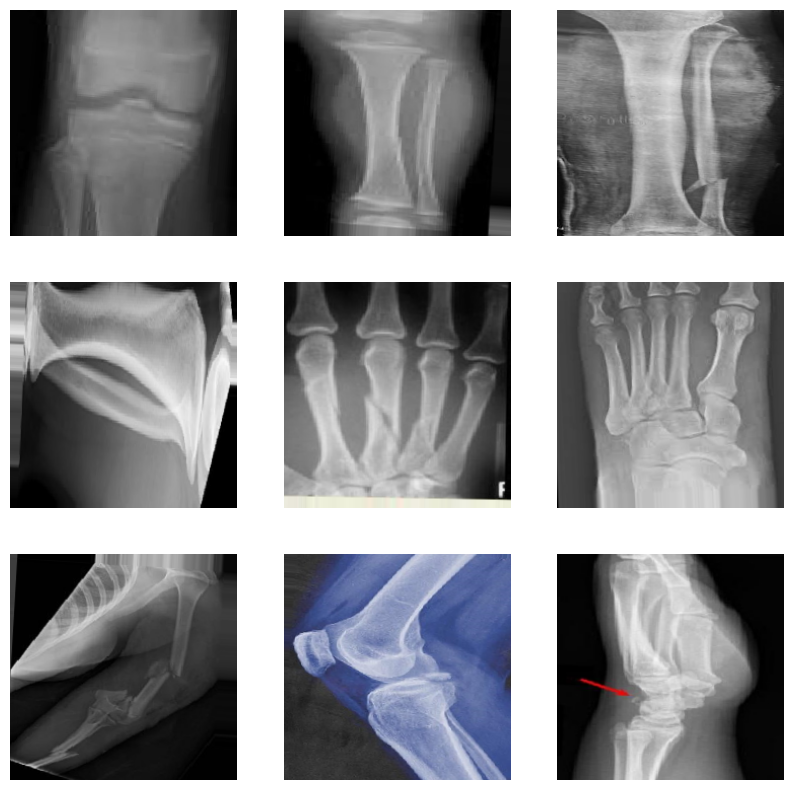

In [ ]:
import matplotlib.pyplot as plt

# Obtenha um lote de imagens pré-processadas
batch = next(training_set)

# Exiba algumas das imagens pré-processadas com os ossos destacados
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch[0][i])
    plt.axis('off')
plt.show()


**Criar diferentes modelos para teste**

A escolha do VGG16 como base para esse modelo é motivada pela sua arquitetura eficaz e desempenho comprovado em tarefas de visão computacional, como reconhecimento de imagens. O VGG16 possui uma arquitetura profunda e bem estruturada, composta por várias camadas convolucionais, o que permite aprender representações complexas das imagens.

In [ ]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:

for layer in vgg.layers:
    layer.trainable = False

In [ ]:

folders = glob('/content/drive/MyDrive/bone_fracture_data_CV/train/*')

Modelo mais complexo

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
x = vgg.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
prediction = Dense(len(folders), activation='softmax')(x)


model2 = Model(inputs=vgg.input, outputs=prediction)

model2.summary()

model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Modelo mais simples

In [ ]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Camada de achatamento (flatten)
x = vgg.output
x = Flatten()(x)

# Camada densa com menos unidades
x = Dense(64, activation='relu')(x)  # Reduzindo para 64 unidades

# Camada de saída
prediction = Dense(len(folders), activation='softmax')(x)

simple_model = Model(inputs=vgg.input, outputs=prediction)

simple_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


Modelo intermediário

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

model4 = Model(inputs=vgg.input, outputs=prediction)

model4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

*Modelo* de CNN sem o VGG16:
Enquanto o VGG16 é uma arquitetura de rede neural convolucional (CNN) profundamente empilhada com 16 camadas, este modelo é mais simples e emprega apenas camadas convolucionais, normalização em lote, max pooling e dropout.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Criar um modelo sequencial
model = Sequential()

# Adicionar camadas convolucionais
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Camadas densas
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))  # 10 classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Resumo do Modelo:")
model.summary()

# Camadas do modelo
print("\nCamadas do Modelo:")
for layer in model.layers:
    print(layer.name)


Resumo do Modelo:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_15 (Ba  (None, 222, 222, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 111, 111, 16)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_16 (Ba  (None, 

In [ ]:
history_cnn =  model.fit(training_set,
                    epochs=50,
                    validation_data=test_set,
                     )

Epoch 1/50
31/31 [==============================] - 17s 541ms/step - loss: 2.2642 - accuracy: 0.2032 - val_loss: 2.6270 - val_accuracy: 0.0857
Epoch 2/50
31/31 [==============================] - 17s 563ms/step - loss: 2.2371 - accuracy: 0.1921 - val_loss: 4.3418 - val_accuracy: 0.1214
Epoch 3/50
31/31 [==============================] - 17s 542ms/step - loss: 2.2334 - accuracy: 0.1830 - val_loss: 2.9561 - val_accuracy: 0.1071
Epoch 4/50
31/31 [==============================] - 17s 543ms/step - loss: 2.1840 - accuracy: 0.1982 - val_loss: 4.0871 - val_accuracy: 0.0929
Epoch 5/50
31/31 [==============================] - 18s 563ms/step - loss: 2.1975 - accuracy: 0.2032 - val_loss: 2.8840 - val_accuracy: 0.1357
Epoch 6/50
31/31 [==============================] - 17s 539ms/step - loss: 2.1769 - accuracy: 0.2154 - val_loss: 3.1127 - val_accuracy: 0.1429
Epoch 7/50
31/31 [==============================] - 17s 541ms/step - loss: 2.1628 - accuracy: 0.2295 - val_loss: 3.1904 - val_accuracy: 0.1429

Treinar os modelos

In [ ]:

# Treinar os modelos
history2 = model2.fit(training_set,
                    epochs=50,
                    validation_data=test_set,
                     )


Epoch 1/10
31/31 [==============================] - 649s 21s/step - loss: 5.5310 - accuracy: 0.1173 - val_loss: 3.5340 - val_accuracy: 0.1286
Epoch 2/10
31/31 [==============================] - 20s 640ms/step - loss: 3.1370 - accuracy: 0.1658 - val_loss: 2.9346 - val_accuracy: 0.1500
Epoch 3/10
31/31 [==============================] - 19s 613ms/step - loss: 2.7325 - accuracy: 0.1911 - val_loss: 2.6744 - val_accuracy: 0.1929
Epoch 4/10
31/31 [==============================] - 20s 629ms/step - loss: 2.5685 - accuracy: 0.1931 - val_loss: 2.5499 - val_accuracy: 0.2143
Epoch 5/10
31/31 [==============================] - 19s 613ms/step - loss: 2.4701 - accuracy: 0.1881 - val_loss: 2.5205 - val_accuracy: 0.1357
Epoch 6/10
31/31 [==============================] - 19s 610ms/step - loss: 2.4176 - accuracy: 0.1759 - val_loss: 2.4201 - val_accuracy: 0.1643
Epoch 7/10
31/31 [==============================] - 19s 610ms/step - loss: 2.3461 - accuracy: 0.1689 - val_loss: 2.4070 - val_accuracy: 0.1643


In [ ]:
# Treinar os modelos
history2 = model2.fit(training_set,
                    epochs=50,
                    validation_data=test_set,
                     )


Epoch 1/50
31/31 [==============================] - 22s 663ms/step - loss: 5.2539 - accuracy: 0.1284 - val_loss: 3.4594 - val_accuracy: 0.1500
Epoch 2/50
31/31 [==============================] - 19s 598ms/step - loss: 3.0951 - accuracy: 0.1729 - val_loss: 2.8220 - val_accuracy: 0.1429
Epoch 3/50
31/31 [==============================] - 18s 583ms/step - loss: 2.6868 - accuracy: 0.1881 - val_loss: 2.6373 - val_accuracy: 0.1571
Epoch 4/50
31/31 [==============================] - 21s 669ms/step - loss: 2.4765 - accuracy: 0.1941 - val_loss: 2.4657 - val_accuracy: 0.1857
Epoch 5/50
31/31 [==============================] - 18s 591ms/step - loss: 2.3691 - accuracy: 0.2133 - val_loss: 2.3553 - val_accuracy: 0.2286
Epoch 6/50
31/31 [==============================] - 19s 623ms/step - loss: 2.2703 - accuracy: 0.2457 - val_loss: 2.3558 - val_accuracy: 0.2429
Epoch 7/50
31/31 [==============================] - 18s 593ms/step - loss: 2.3071 - accuracy: 0.2093 - val_loss: 2.4027 - val_accuracy: 0.2071

In [ ]:
history4 = model4.fit(training_set,
                    epochs=10,
                    validation_data=test_set,
                     )


Epoch 1/10
31/31 [==============================] - 23s 714ms/step - loss: 2.4914 - accuracy: 0.1800 - val_loss: 2.3842 - val_accuracy: 0.2786
Epoch 2/10
31/31 [==============================] - 19s 614ms/step - loss: 1.9575 - accuracy: 0.3286 - val_loss: 2.2170 - val_accuracy: 0.2500
Epoch 3/10
31/31 [==============================] - 20s 653ms/step - loss: 1.7470 - accuracy: 0.4146 - val_loss: 2.2324 - val_accuracy: 0.2643
Epoch 4/10
31/31 [==============================] - 19s 616ms/step - loss: 1.6247 - accuracy: 0.4489 - val_loss: 2.2141 - val_accuracy: 0.2857
Epoch 5/10
31/31 [==============================] - 20s 654ms/step - loss: 1.5894 - accuracy: 0.4489 - val_loss: 2.6538 - val_accuracy: 0.2786
Epoch 6/10
31/31 [==============================] - 19s 601ms/step - loss: 1.5131 - accuracy: 0.4954 - val_loss: 2.2564 - val_accuracy: 0.2786
Epoch 7/10
31/31 [==============================] - 20s 652ms/step - loss: 1.4261 - accuracy: 0.5046 - val_loss: 2.4534 - val_accuracy: 0.3071

In [ ]:
history4 = model4.fit(training_set,
                    epochs=50,
                    validation_data=test_set,
                     )


Epoch 1/50
31/31 [==============================] - 56s 2s/step - loss: 2.8281 - accuracy: 0.1638 - val_loss: 2.3804 - val_accuracy: 0.1571
Epoch 2/50
31/31 [==============================] - 20s 645ms/step - loss: 2.0055 - accuracy: 0.3124 - val_loss: 2.1784 - val_accuracy: 0.3000
Epoch 3/50
31/31 [==============================] - 20s 658ms/step - loss: 1.8345 - accuracy: 0.3731 - val_loss: 2.2748 - val_accuracy: 0.2071
Epoch 4/50
31/31 [==============================] - 20s 636ms/step - loss: 1.7379 - accuracy: 0.4075 - val_loss: 2.3234 - val_accuracy: 0.2714
Epoch 5/50
31/31 [==============================] - 19s 628ms/step - loss: 1.6109 - accuracy: 0.4601 - val_loss: 2.2565 - val_accuracy: 0.3214
Epoch 6/50
31/31 [==============================] - 18s 596ms/step - loss: 1.4895 - accuracy: 0.5086 - val_loss: 2.2385 - val_accuracy: 0.3143
Epoch 7/50
31/31 [==============================] - 20s 621ms/step - loss: 1.3561 - accuracy: 0.5399 - val_loss: 2.0674 - val_accuracy: 0.3929
Ep

In [ ]:
simple_model_history = simple_model.fit(training_set,
                    epochs=50,
                    validation_data=test_set,
                     )

Epoch 1/50
31/31 [==============================] - 22s 685ms/step - loss: 2.5274 - accuracy: 0.1314 - val_loss: 2.3213 - val_accuracy: 0.1143
Epoch 2/50
31/31 [==============================] - 18s 596ms/step - loss: 2.3046 - accuracy: 0.1132 - val_loss: 2.3009 - val_accuracy: 0.1357
Epoch 3/50
31/31 [==============================] - 21s 693ms/step - loss: 2.2934 - accuracy: 0.1163 - val_loss: 2.3001 - val_accuracy: 0.1357
Epoch 4/50
31/31 [==============================] - 18s 591ms/step - loss: 2.2964 - accuracy: 0.1385 - val_loss: 2.2991 - val_accuracy: 0.1357
Epoch 5/50
31/31 [==============================] - 19s 627ms/step - loss: 2.2940 - accuracy: 0.1385 - val_loss: 2.2981 - val_accuracy: 0.1357
Epoch 6/50
31/31 [==============================] - 18s 594ms/step - loss: 2.2919 - accuracy: 0.1385 - val_loss: 2.2975 - val_accuracy: 0.1357
Epoch 7/50
31/31 [==============================] - 20s 635ms/step - loss: 2.2899 - accuracy: 0.1385 - val_loss: 2.2967 - val_accuracy: 0.1357

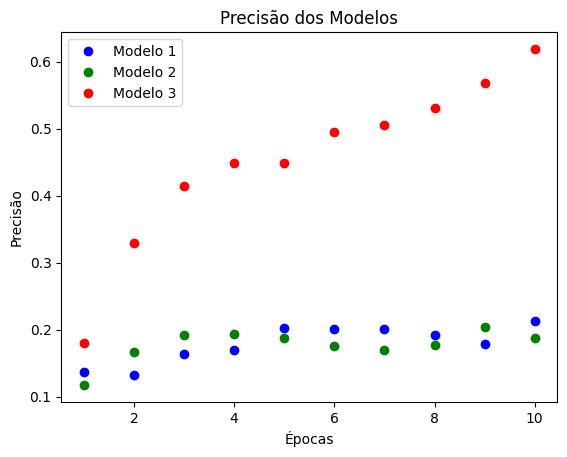

In [ ]:
import matplotlib.pyplot as plt

# Histórico de precisão dos três modelos
accuracy1 = simple_model_history.history['accuracy']
accuracy2 = history2.history['accuracy']
accuracy3 = history4.history['accuracy']

# Número de épocas
epochs = range(1, len(accuracy1) + 1)

# Plotando a precisão dos três modelos
plt.plot(epochs, accuracy1, 'bo', label='Modelo 1')
plt.plot(epochs, accuracy2, 'go', label='Modelo 2')
plt.plot(epochs, accuracy3, 'ro', label='Modelo 3')

plt.title('Precisão dos Modelos com 10 épocas')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

plt.show()


Modelo 1 = Modelo mais simples

Modelo 2 = Modelo mais complexo

Modelo 3 = Modelo intermediário

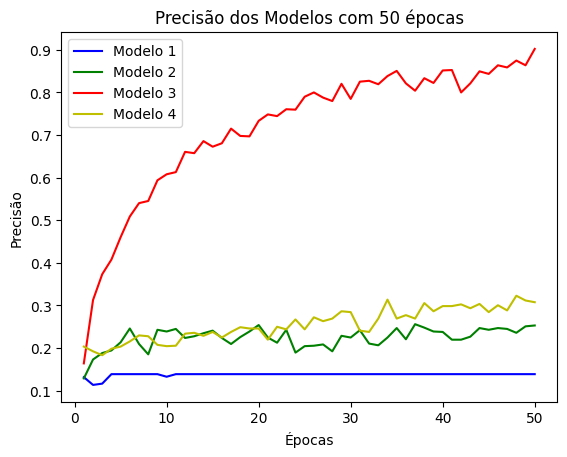

In [ ]:
import matplotlib.pyplot as plt

# Histórico de precisão dos três modelos
accuracy1 = simple_model_history.history['accuracy']
accuracy2 = history2.history['accuracy']
accuracy3 = history4.history['accuracy']
accuracy4 = history_cnn.history['accuracy']

# Número de épocas
epochs = range(1, len(accuracy1) + 1)

# Plotando a precisão dos três modelos
plt.plot(epochs, accuracy1, 'b-', label='Modelo 1')
plt.plot(epochs, accuracy2, 'g-', label='Modelo 2')
plt.plot(epochs, accuracy3, 'r-', label='Modelo 3')
plt.plot(epochs, accuracy4, 'y-', label='Modelo 4')

plt.title('Precisão dos Modelos com 50 épocas')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

plt.show()


Modelo 1 = Modelo mais simples

Modelo 2 = Modelo mais complexo

Modelo 3 = Modelo intermediário

Modelo 4 = Modelo sequencial

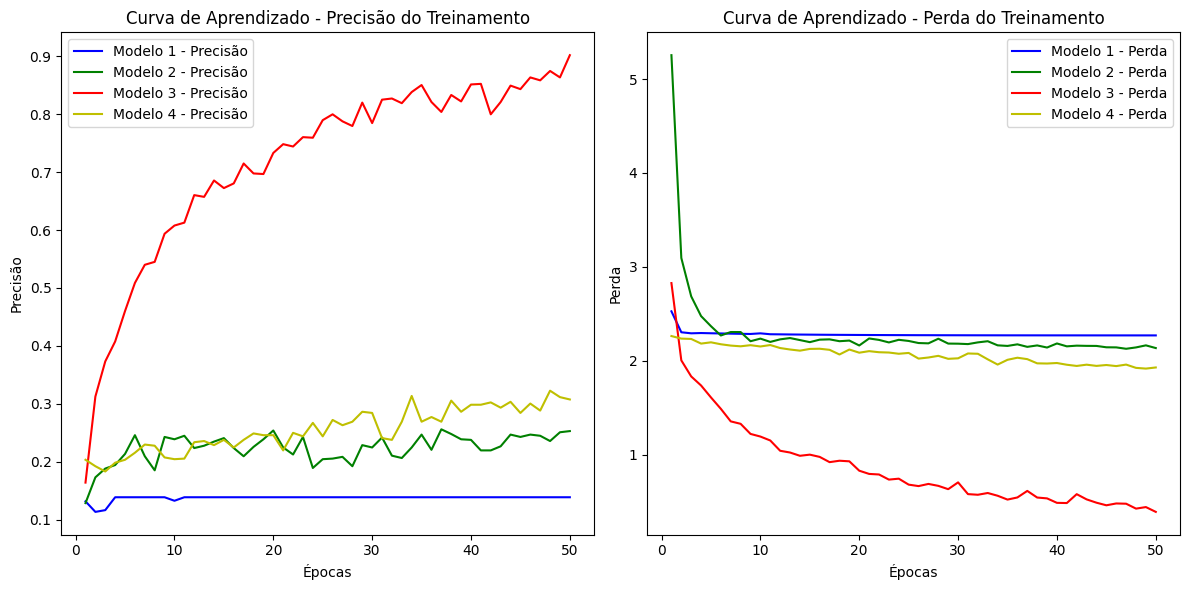

In [ ]:
import matplotlib.pyplot as plt

# Precisão do treinamento
train_accuracy1 = simple_model_history.history['accuracy']
train_accuracy2 = history2.history['accuracy']
train_accuracy3 = history4.history['accuracy']
train_accuracy4 = history_cnn.history['accuracy']

# Perda do treinamento
train_loss1 = simple_model_history.history['loss']
train_loss2 = history2.history['loss']
train_loss3 = history4.history['loss']
train_loss4 = history_cnn.history['loss']

# Número de épocas
epochs = range(1, len(train_accuracy1) + 1)

# Plotando as curvas de aprendizado para precisão
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy1, 'b-', label='Modelo 1 - Precisão')
plt.plot(epochs, train_accuracy2, 'g-', label='Modelo 2 - Precisão')
plt.plot(epochs, train_accuracy3, 'r-', label='Modelo 3 - Precisão')
plt.plot(epochs, train_accuracy4, 'y-', label='Modelo 4 - Precisão')

plt.title('Curva de Aprendizado - Precisão do Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

# Plotando as curvas de aprendizado para perda
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss1, 'b-', label='Modelo 1 - Perda')
plt.plot(epochs, train_loss2, 'g-', label='Modelo 2 - Perda')
plt.plot(epochs, train_loss3, 'r-', label='Modelo 3 - Perda')
plt.plot(epochs, train_loss4, 'y-', label='Modelo 4 - Perda')

plt.title('Curva de Aprendizado - Perda do Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


Modelo 1 = Modelo mais simples

Modelo 2 = Modelo mais complexo

Modelo 3 = Modelo intermediário

Modelo 4 = Modelo sequencial

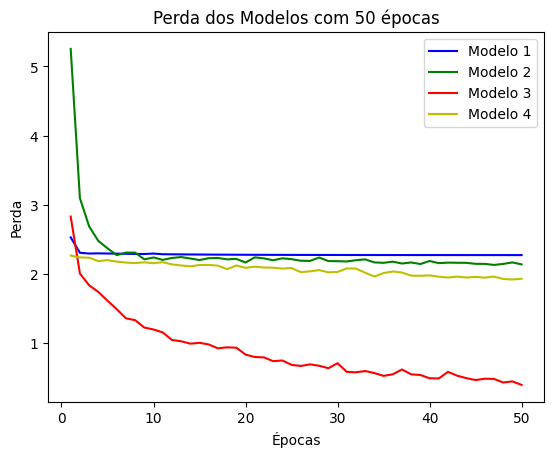

In [ ]:
import matplotlib.pyplot as plt

# Histórico de perda dos três modelos
loss1 = simple_model_history.history['loss']
loss2 = history2.history['loss']
loss3 = history4.history['loss']
loss4 = history_cnn.history['loss']

# Número de épocas
epochs = range(1, len(loss1) + 1)

# Plotando a perda dos três modelos
plt.plot(epochs, loss1, 'b-', label='Modelo 1')
plt.plot(epochs, loss2, 'g-', label='Modelo 2')
plt.plot(epochs, loss3, 'r-', label='Modelo 3')
plt.plot(epochs, loss4, 'y-', label='Modelo 4')

plt.title('Perda dos Modelos com 50 épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()


Modelo 1 = Modelo mais simples

Modelo 2 = Modelo mais complexo

Modelo 3 = Modelo intermediário

Modelo 4 = Modelo sequencial

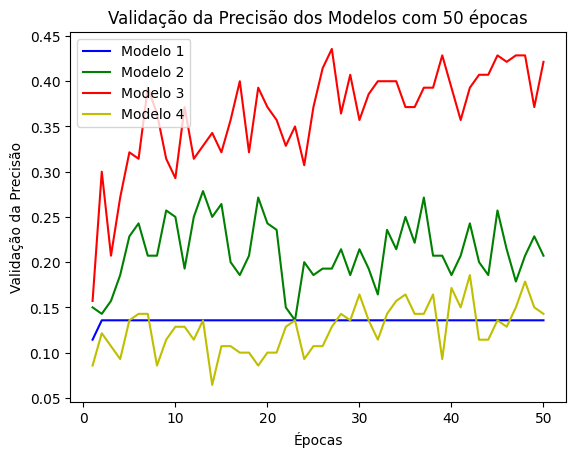

In [ ]:
import matplotlib.pyplot as plt

# Histórico de validação da precisão dos três modelos
val_accuracy1 = simple_model_history.history['val_accuracy']
val_accuracy2 = history2.history['val_accuracy']
val_accuracy3 = history4.history['val_accuracy']
val_accuracy4 = history_cnn.history['val_accuracy']

# Número de épocas
epochs = range(1, len(val_accuracy1) + 1)

# Plotando a validação da precisão dos três modelos
plt.plot(epochs, val_accuracy1, 'b-', label='Modelo 1')
plt.plot(epochs, val_accuracy2, 'g-', label='Modelo 2')
plt.plot(epochs, val_accuracy3, 'r-', label='Modelo 3')
plt.plot(epochs, val_accuracy4, 'y-', label='Modelo 4')

plt.title('Validação da Precisão dos Modelos com 50 épocas')
plt.xlabel('Épocas')
plt.ylabel('Validação da Precisão')
plt.legend()

plt.show()


Modelo 1 = Modelo mais simples

Modelo 2 = Modelo mais complexo

Modelo 3 = Modelo intermediário

Modelo 4 = Modelo sequencial

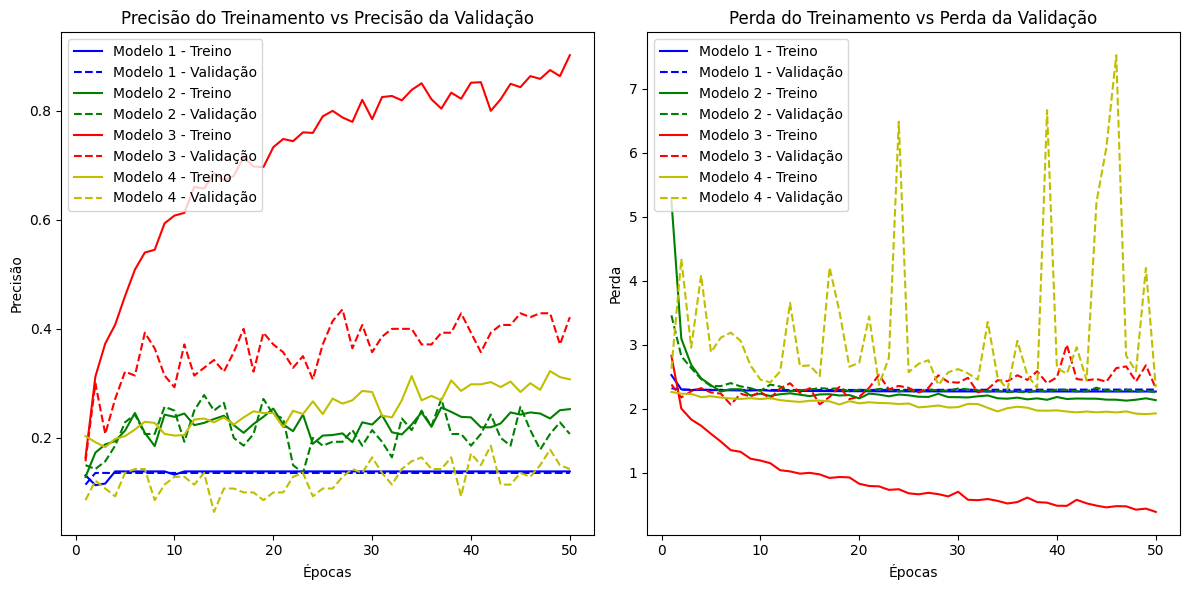

In [ ]:
import matplotlib.pyplot as plt

# Precisão do treinamento
train_accuracy1 = simple_model_history.history['accuracy']
train_accuracy2 = history2.history['accuracy']
train_accuracy3 = history4.history['accuracy']
train_accuracy4 = history_cnn.history['accuracy']

# Precisão da validação
val_accuracy1 = simple_model_history.history['val_accuracy']
val_accuracy2 = history2.history['val_accuracy']
val_accuracy3 = history4.history['val_accuracy']
val_accuracy4 = history_cnn.history['val_accuracy']

# Perda do treinamento
train_loss1 = simple_model_history.history['loss']
train_loss2 = history2.history['loss']
train_loss3 = history4.history['loss']
train_loss4 = history_cnn.history['loss']

# Perda da validação
val_loss1 = simple_model_history.history['val_loss']
val_loss2 = history2.history['val_loss']
val_loss3 = history4.history['val_loss']
val_loss4 = history_cnn.history['val_loss']

# Número de épocas
epochs = range(1, len(train_accuracy1) + 1)

# Plotando a precisão do treinamento vs precisão da validação
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy1, 'b-', label='Modelo 1 - Treino')
plt.plot(epochs, val_accuracy1, 'b--', label='Modelo 1 - Validação')
plt.plot(epochs, train_accuracy2, 'g-', label='Modelo 2 - Treino')
plt.plot(epochs, val_accuracy2, 'g--', label='Modelo 2 - Validação')
plt.plot(epochs, train_accuracy3, 'r-', label='Modelo 3 - Treino')
plt.plot(epochs, val_accuracy3, 'r--', label='Modelo 3 - Validação')
plt.plot(epochs, train_accuracy4, 'y-', label='Modelo 4 - Treino')
plt.plot(epochs, val_accuracy4, 'y--', label='Modelo 4 - Validação')

plt.title('Precisão do Treinamento vs Precisão da Validação')
plt.xlabel('Épocas')
plt.ylabel('Precisão')
plt.legend()

# Plotando a perda do treinamento vs perda da validação
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss1, 'b-', label='Modelo 1 - Treino')
plt.plot(epochs, val_loss1, 'b--', label='Modelo 1 - Validação')
plt.plot(epochs, train_loss2, 'g-', label='Modelo 2 - Treino')
plt.plot(epochs, val_loss2, 'g--', label='Modelo 2 - Validação')
plt.plot(epochs, train_loss3, 'r-', label='Modelo 3 - Treino')
plt.plot(epochs, val_loss3, 'r--', label='Modelo 3 - Validação')
plt.plot(epochs, train_loss4, 'y-', label='Modelo 4 - Treino')
plt.plot(epochs, val_loss4, 'y--', label='Modelo 4 - Validação')

plt.title('Perda do Treinamento vs Perda da Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


Modelo 1 = Modelo mais simples

Modelo 2 = Modelo mais complexo

Modelo 3 = Modelo intermediário

Modelo 4 = Modelo sequencial

Conclusão: Após processar as imagens, estudar sobre os modelos de classificação e defini-los, eles passaram por um intenso processo de treinamento para medir suas performances. O modelo que apresentou um melhor desempenho foi o 3, entretanto vale ressaltar que houve um overfitting, já que a precisão no treino foi maior que a precisão nos testes. Muito disso também se dá pela complexidade dos dados, já que grande parte deles são de diferentes partes do corpo humano e não indicam onde ocorreu a fratura. Com um maior estudo dos dados, testes de processamento e análise de modelos, com certeza é possível obter melhores resultados, mas creio que foge um pouco do escopo do desafio.